In [1]:
!make -C .. download_tree_canopy swiss_dem

make: Entering directory '/home/martibosch/data-science/invest-heat-islands'
make: Nothing to be done for 'download_tree_canopy'.
make: Nothing to be done for 'swiss_dem'.
make: Leaving directory '/home/martibosch/data-science/invest-heat-islands'


In [2]:
import contextily as ctx
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
from matplotlib import cm, colors
from rasterio import features, mask, plot, transform, warp
from rasterio.enums import Resampling

figwidth, figheight = plt.rcParams['figure.figsize']

In [3]:
WEB_MERCATOR_CRS = 'epsg:3857'
ESRI_RELIEF_URI = 'https://server.arcgisonline.com/ArcGIS/rest/services/' \
    'World_Shaded_Relief/MapServer/tile/{z}/{y}/{x}'

agglom_extent_filepath = '../data/raw/agglom-extent/agglom-extent.shp'
tree_canopy_filepath = '../data/raw/tree-canopy.tif'
swiss_dem_filepath = '../data/interim/swiss-dem.tif'

spatial_extent_filepath = '../reports/figures/spatial-extent.pdf'

## Read and preprocess the data

Read the agglomeration extent shapefile, which has been computed with the [Urban footprinter](https://github.com/martibosch/urban-footprinter) library following the methods used in the [Atlas of Urban Expansion](http://atlasofurbanexpansion.org/).

In [4]:
# select first row while still having an iterable geo series
agglom_extent_gser = gpd.read_file(agglom_extent_filepath).to_crs(
    WEB_MERCATOR_CRS)['geometry'].iloc[:1]

/home/martibosch/anaconda3/envs/invest-heat-islands/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Read the agglomeration rasters, crop them to the agglomeration extent and reproject them

In [5]:
def reproject_raster(src_crs,
                     src_arr,
                     src_bounds,
                     src_transform,
                     dst_crs=WEB_MERCATOR_CRS,
                     dst_nodata=0):
    dst_transform, dst_width, dst_height = warp.calculate_default_transform(
        src_crs, dst_crs, src_arr.shape[1], src_arr.shape[0], *src_bounds)

    # use a float dtype so that the array can have nan values, which will be
    # transparent in the plot
    dst_arr = np.full((dst_height, dst_width), dst_nodata, dtype=src_arr.dtype)
    _ = warp.reproject(src_arr,
                       dst_arr,
                       src_transform=src_transform,
                       src_crs=src_crs,
                       dst_transform=dst_transform,
                       dst_crs=dst_crs,
                       dst_nodata=dst_nodata)
    # dst_arr[dst_arr == 0] = np.nan
    return dst_arr, dst_transform

In [6]:
with rio.open(swiss_dem_filepath) as src:
    src_crs = src.crs
    dem_arr, dem_transform = mask.mask(src,
                                       agglom_extent_gser.to_crs(src_crs),
                                       all_touched=True,
                                       crop=True)
    dem_arr = dem_arr[0]  # single-band raster
    dem_arr[dem_arr == src.nodata] = np.nan
    dem_arr, dem_transform = reproject_raster(src_crs,
                                              dem_arr,
                                              transform.array_bounds(
                                                  *dem_arr.shape,
                                                  dem_transform),
                                              dem_transform,
                                              dst_nodata=np.nan)

In [7]:
downscale_factor = 10
with rio.open(tree_canopy_filepath) as src:
    src_width, src_height = src.width, src.height
    out_shape = int(src_height / downscale_factor), int(src_width /
                                                        downscale_factor)
    tree_canopy_arr, tree_canopy_transform = reproject_raster(
        src.crs,
        src.read(1, out_shape=out_shape, resampling=Resampling.nearest),
        src.bounds,
        src.transform * src.transform.scale(src_width / out_shape[1],
                                            src_height / out_shape[0]),
        dst_nodata=0)
# tree_canopy_arr = tree_canopy_arr.astype(np.float32)
# tree_canopy_arr[tree_canopy_arr == 0] = np.nan

## Prepare the colormaps

### Prepare a colormap for the tree canopy map

See: https://stackoverflow.com/questions/37327308/add-alpha-to-an-existing-matplotlib-colormap

In [8]:
num_steps = 10

# Choose colormap
# cmap = cm.Greens

# Get the colormap colors
# tree_cmap = cmap(np.arange(num_steps))
tree_cmap = np.stack([[0, 0.5, 0, 0] for _ in range(num_steps)])

# Set alpha
tree_cmap[:,-1] = np.linspace(0, 1, num_steps)

# Create new colormap
tree_cmap = colors.ListedColormap(tree_cmap)

### Prepare a colormap for the DEM

See:

* To truncate an existing color map: https://stackoverflow.com/questions/35920887/select-part-of-the-colormap-plotting-terrain
* To make an existing color map darker: https://scipy-cookbook.readthedocs.io/items/Matplotlib_ColormapTransformations.html

In [9]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


def cmap_map(function, cmap):
    """ Applies function (which should operate on vectors of shape 3: [r, g, b]), on colormap cmap.
    This routine will break any discontinuous points in a colormap.
    """
    cdict = cmap._segmentdata
    step_dict = {}
    # Firt get the list of points where the segments start or end
    for key in ('red', 'green', 'blue'):
        step_dict[key] = list(map(lambda x: x[0], cdict[key]))
    step_list = sum(step_dict.values(), [])
    step_list = np.array(list(set(step_list)))
    # Then compute the LUT, and apply the function to the LUT
    reduced_cmap = lambda step: np.array(cmap(step)[0:3])
    old_LUT = np.array(list(map(reduced_cmap, step_list)))
    new_LUT = np.array(list(map(function, old_LUT)))
    # Now try to make a minimal segment definition of the new LUT
    cdict = {}
    for i, key in enumerate(['red', 'green', 'blue']):
        this_cdict = {}
        for j, step in enumerate(step_list):
            if step in step_dict[key]:
                this_cdict[step] = new_LUT[j, i]
            elif new_LUT[j, i] != old_LUT[j, i]:
                this_cdict[step] = new_LUT[j, i]
        colorvector = list(map(lambda x: x + (x[1], ), this_cdict.items()))
        colorvector.sort()
        cdict[key] = colorvector

    return colors.LinearSegmentedColormap('colormap', cdict, 1024)


# cmap = plt.get_cmap('terrain')
dem_cmap = truncate_colormap(cmap_map(lambda x: x * .9, cm.terrain), .4, .65)

## Plot

In [10]:
def plot_raster(raster_arr,
                raster_transform,
                ax,
                cmap,
                basemap_uri=None,
                **imshow_kws):
    # plot.show(raster_arr, transform=raster_transform, ax=ax)
    # ax.set_xlim([west, east])
    # ax.set_ylim([south, north])
    agglom_extent_gser.plot(alpha=0, ax=ax)
    ax.margins(x=.14, y=.2)

    if basemap_uri is None:
        basemap_uri = ESRI_RELIEF_URI
    ctx.add_basemap(ax, source=basemap_uri)
    plot.show(raster_arr,
              transform=raster_transform,
              ax=ax,
              cmap=cmap,
              **imshow_kws)
    ax.set_axis_off()
    return ax

/home/martibosch/anaconda3/envs/invest-heat-islands/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  from ipykernel import kernelapp as app


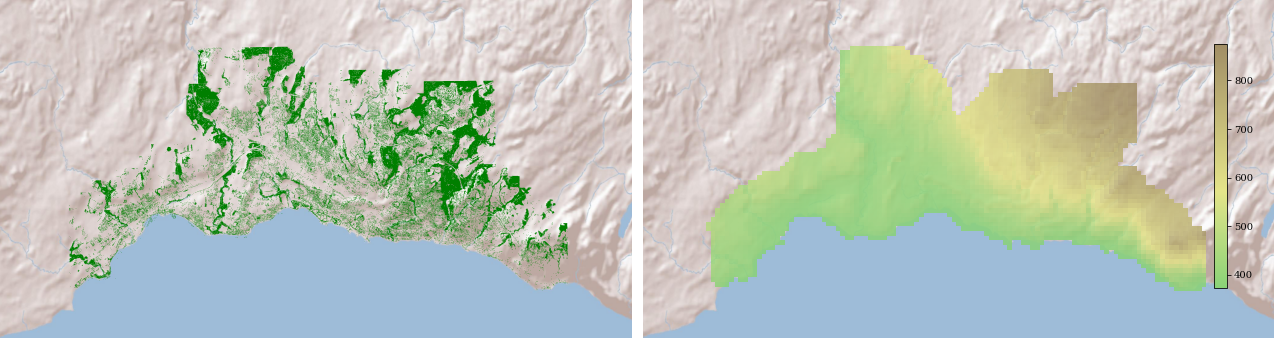

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(18, 16))

plot_raster(tree_canopy_arr, tree_canopy_transform, axes[0], tree_cmap)
plot_raster(dem_arr, dem_transform, axes[1], dem_cmap, alpha=0.85)

# See: https://bit.ly/2yZ4q5i
box = axes[1].get_position()
# axes[1].set_position([box.x0*1.05, box.y0, box.width, box.height])
ax_colorbar = plt.axes(
    [box.x0 * 1.05 + box.width * 1.05, box.y0, 0.01, box.height])
plt.colorbar(cm.ScalarMappable(plt.Normalize(np.nanmin(dem_arr),
                                             np.nanmax(dem_arr)),
                               cmap=dem_cmap),
             cax=ax_colorbar)
fig.tight_layout()
fig.savefig('../reports/figures/tree-canopy-dem-extent.pdf')